In [9]:
import os
import cv2
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt

In [12]:
label_map = np.array([
    (0, 0, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 128, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128),  # tv/monitor
])

In [14]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()
  
    # Create 3 Numpy arrays containing zeros.
    # Later each pixel will be filled with respective red, green, and blue pixels
    # depending on the predicted class.
  
    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)
  
    for label_num in range(0, len(label_map)):
        index = labels == label_num
         
        R, G, B = label_map[label_num]
  
        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B
  
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map

In [16]:
def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum
  
    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
  
    return image

In [22]:
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights, 
                                             DeepLabV3_ResNet101_Weights, 
                                             DeepLabV3_MobileNet_V3_Large_Weights
                                             )

In [26]:
def load_model(model_name: str):
    if model_name.lower() not in ("mobilenet", "resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('mobilenet', 'resnet_50', 'resnet_101')")
         
    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
  
    elif model_name == "resnet_101":
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
     
    else:
        model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
        transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
  
    model.eval()
  
    # Warmup run
     
    _ = model(torch.randn(1, 3, 520, 520))
     
    return model, transforms

In [44]:
def perform_inference(model_name: str, num_images=10, image_dir=None, save_images=False, device=None):
     
    if save_images:
        seg_map_save_dir = os.path.join("results", model_name, "segmentation_map")
        overlayed_save_dir = os.path.join("results", model_name, "overlayed_images")
         
        os.makedirs(seg_map_save_dir, exist_ok=True)
        os.makedirs(overlayed_save_dir, exist_ok=True)
     
    device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
    model, transforms = load_model(model_name)
    model.to(device)
  
    # Load image handles for the validation set.
    with open(r"./content/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt") as f:
        val_set_image_names = f.read().split("\n")
  
    # Randomly select 'num_images' from the whole set for inference.
    selected_images = np.random.choice(val_set_image_names, num_images, replace=False)
  
    # Iterate over selected images
    for img_handle in selected_images:
         
        # Load and pre-process image.
        image_name = img_handle + ".jpg"
        image_path = os.path.join(image_dir, image_name)
        img_raw = PIL.Image.open(image_path).convert("RGB")
        W, H = img_raw.size[:2]
        img_t = transforms(img_raw)
        img_t = torch.unsqueeze(img_t, dim=0).to(device)
  
        # Model Inference
        with torch.no_grad():
            output = model(img_t)["out"].cpu()
  
        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)
  
        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
        overlayed_image = image_overlay(img_raw, segmented_image)
         
        # Plot
        plt.figure(figsize=(12, 10), dpi=100)
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Image")
        plt.imshow(np.asarray(img_raw))
  
        plt.subplot(1, 3, 2)
        plt.title("Segmentation")
        plt.axis("off")
        plt.imshow(segmented_image)
  
        plt.subplot(1, 3, 3)
        plt.title("Overlayed")
        plt.axis("off")
        plt.imshow(overlayed_image[:, :, ::-1])

        plt.show()
        plt.close()
  
        # Save Segmented and overlayed images
        if save_images:
            cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
            cv2.imwrite(overlayed_save_dir, overlayed_image)
  
    return

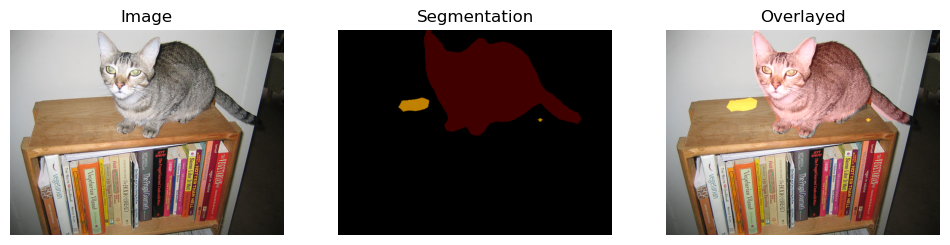

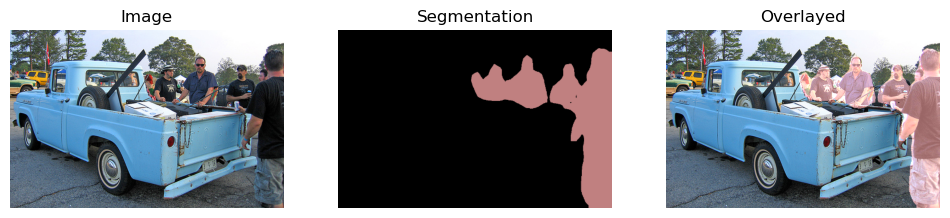

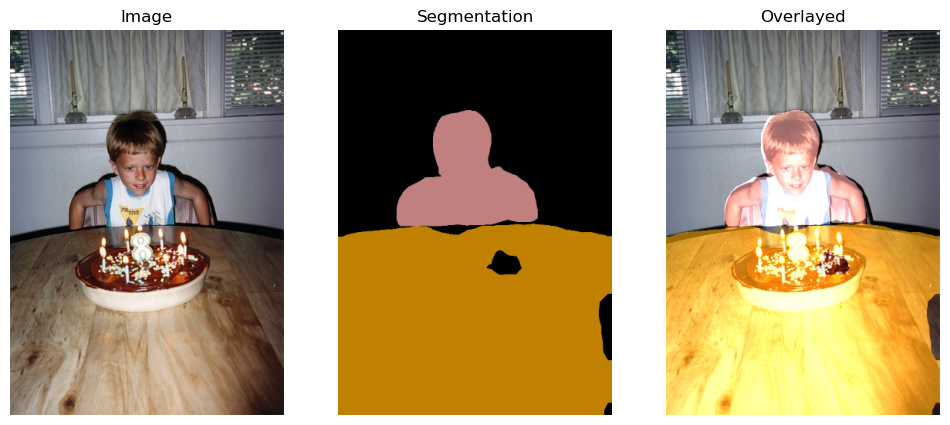

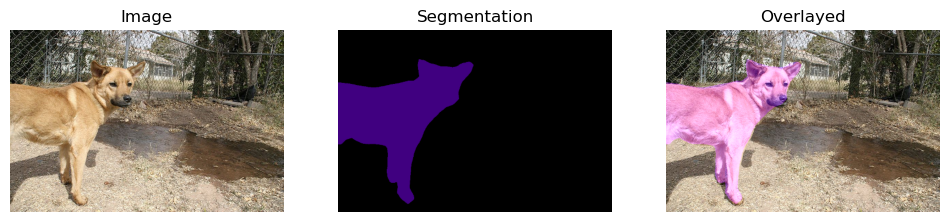

In [46]:
ROOT_raw_image_directory = r"./content/VOCdevkit/VOC2012/JPEGImages"
  
model_name = 'mobilenet' # "mobilenet", "resnet_50", resnet_101
num_images = 4
save = False
  
perform_inference(
    model_name=model_name, 
    num_images=num_images, 
    save_images=save, 
    image_dir=ROOT_raw_image_directory
)